In [116]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
import os, time
from tqdm import tqdm
import torch.nn as nn
from collections import OrderedDict
#from models import loss, cVAE

In [117]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation = True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))
    def forward(self, x):
        return self.mlp(x)
    
class Encoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Encoder, self).__init__()
        c, h, w = shape
        ww = ((w-8)//2 - 4)//2
        hh = ((h-8)//2 - 4)//2
        self.encode = nn.Sequential(nn.Conv2d(c, 16, 5, padding = 0), nn.BatchNorm2d(16), nn.ReLU(inplace = True), 
                                    nn.Conv2d(16, 32, 5, padding = 0), nn.BatchNorm2d(32), nn.ReLU(inplace = True), 
                                    nn.MaxPool2d(2, 2),
                                    nn.Conv2d(32, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True), 
                                    nn.Conv2d(64, 64, 3, padding = 0), nn.BatchNorm2d(64), nn.ReLU(inplace = True), 
                                    nn.MaxPool2d(2, 2),
                                    Flatten(), MLP([ww*hh*64, 256, 128])
                                   )
        self.calc_mean = MLP([128+ncond, 64, nhid], last_activation = False)
        self.calc_logvar = MLP([128+ncond, 64, nhid], last_activation = False)
    def forward(self, x, y = None):
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            return self.calc_mean(torch.cat((x, y), dim=1)), self.calc_logvar(torch.cat((x, y), dim=1))

class Decoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Decoder, self).__init__()
        c, w, h = shape
        self.shape = shape
        self.decode = nn.Sequential(MLP([nhid+ncond, 64, 128, 256, c*w*h], last_activation = False), nn.Sigmoid())
    def forward(self, z, y = None):
        c, w, h = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w, h)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w, h)


In [118]:
class cVAE(nn.Module):
    def __init__(self, shape, nclass, nhid = 16, ncond = 16):
        super(cVAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid, ncond = ncond)
        self.decoder = Decoder(shape, nhid, ncond = ncond)
        self.label_embedding = nn.Embedding(nclass, ncond)
        
    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma
    
    def forward(self, x, y):
        y = self.label_embedding(y)
        mean, logvar = self.encoder(x, y)
        z = self.sampling(mean, logvar)
        return self.decoder(z, y), mean, logvar

    def generate(self, class_idx):
        tclass = type(class_idx)
        #print("Working")
        #print(tclass)
        if (type(class_idx) is int):
            class_idx = torch.tensor(class_idx)
        class_idx = class_idx.to(device)
        if (len(class_idx.shape) == 0):
            batch_size = None
            #print(batch_size)
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device) 
        y = self.label_embedding(class_idx)
        res = self.decoder(z, y)
        if not batch_size:
            res = res.squeeze(0)
        return res
    

    
BCE_loss = nn.BCELoss(reduction = "sum")
def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KL_divergence

In [119]:
def crop(x, low, high):
    x[x<=low] = low
    x[x>=high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.))
])

train_data = torchvision.datasets.MNIST(root='/datasets', train=True, download=True, transform=transform)
train_iter = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = cVAE((1, 28, 28), 10, nhid = 2, ncond = 16)
net.to(device)
#print(net)

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

In [121]:
lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay = 0.0001)

def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

retrain = True
if os.path.exists(save_name):
    print("Model parameters have already been trained before. Retrain ? (y/n)")
    ans = input()
    if not (ans == 'y'):
        checkpoint = torch.load(save_name, map_location = device)
        net.load_state_dict(checkpoint["net"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        for g in optimizer.param_groups:
            g['lr'] = lr
        
max_epochs = 50
net = net.to(device)

In [122]:
print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm(train_iter, ncols = 50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))
    
    adjust_lr(optimizer)

  0%|                     | 0/118 [00:00<?, ?it/s]

training on  cpu


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 0, train loss 161.2360 , time 366.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 1, train loss 135.5052 , time 75.5 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 2, train loss 131.8830 , time 77.9 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 3, train loss 130.6464 , time 76.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 4, train loss 129.6698 , time 76.5 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 5, train loss 128.8231 , time 76.5 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 6, train loss 128.3577 , time 76.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 7, train loss 127.7691 , time 76.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 8, train loss 127.6775 , time 77.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 9, train loss 126.9481 , time 76.2 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 10, train loss 126.6780 , time 78.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 11, train loss 126.3077 , time 77.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 12, train loss 126.1411 , time 77.2 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 13, train loss 126.0175 , time 78.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 14, train loss 125.5782 , time 214.2 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 15, train loss 125.6191 , time 77.6 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 16, train loss 125.0936 , time 76.7 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 17, train loss 124.8996 , time 94.6 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 18, train loss 124.7434 , time 169.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 19, train loss 124.6446 , time 76.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 20, train loss 125.2006 , time 76.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 21, train loss 124.7419 , time 133.0 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 22, train loss 124.3163 , time 168.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 23, train loss 124.1154 , time 172.9 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 24, train loss 123.9228 , time 89.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 25, train loss 123.9317 , time 75.5 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 26, train loss 123.7856 , time 76.6 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 27, train loss 123.5466 , time 123.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 28, train loss 123.4696 , time 141.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 29, train loss 123.2554 , time 76.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 30, train loss 123.0895 , time 112.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 31, train loss 122.8589 , time 98.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 32, train loss 122.6952 , time 76.7 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 33, train loss 122.6711 , time 110.5 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 34, train loss 122.5661 , time 188.2 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 35, train loss 122.4129 , time 100.1 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 36, train loss 122.3494 , time 192.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 37, train loss 122.1493 , time 77.7 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 38, train loss 122.0896 , time 76.6 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 39, train loss 121.9317 , time 77.7 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 40, train loss 121.9192 , time 78.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 41, train loss 121.8269 , time 139.3 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 42, train loss 121.6379 , time 194.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 43, train loss 121.6222 , time 77.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 44, train loss 121.6010 , time 76.4 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 45, train loss 121.5862 , time 76.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 46, train loss 121.5410 , time 77.2 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 47, train loss 121.4149 , time 76.8 sec


  0%|                     | 0/118 [00:00<?, ?it/s]

epoch 48, train loss 121.3013 , time 76.2 sec


100%|███████████| 118/118 [01:15<00:00,  1.56it/s]

epoch 49, train loss 121.3082 , time 75.8 sec


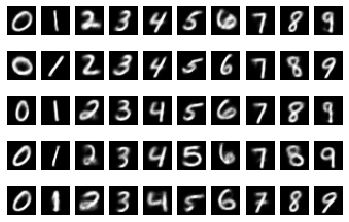

In [124]:
from matplotlib import cm

with torch.no_grad():
    x = net.generate(torch.tensor([list(range(10))] * 5).clone().view(-1))
    
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.axis("off")
    plt.imshow(x[i].squeeze(0).cpu().numpy(), cm.gray)